# 2025-02-03 Chebyshev collocation

## Last time

* Discuss reading
* Arbitrary order discretization
* Method of manufactured solutions
* Techniques for boundary conditions
* Fourier analysis of stencils

## Today

* Fourier analysis ctd.
* Conditioning of Vandermonde matrices
* Chebyshev polynomials
* Solving Poisson using Chebyshev polynomials

# Fourier analysis of stencils

Consider the plane waves $\phi(x, \theta) = e^{i\theta x}$.

Sample $\phi$ on a discrete grid $x = \mathbb Z$ and apply the stencil
\begin{align}
S \phi(x, \theta) &= s_{-1} \phi(x-1, \theta) + s_{0} \phi(x, \theta) + s_1 \phi(x+1,\theta) \\
&= \Big( s_{-1} e^{-i\theta} + s_0 + s_{1} e^{i\theta} \Big) \phi(x, \theta)
\end{align}
With $S = \begin{bmatrix} -1 & 2 & -1 \end{bmatrix}$, we get
$$S \phi(x, \theta) = \underbrace{(2 - 2 \cos\theta)}_{\hat S(\theta)} \phi(x, \theta)$$
We call $\hat S(\theta)$ the *symbol* of the operator.

**(Group) exercise**: What is the symbol of the continuous second derivative?

Solution: imagine the stencil points getting closer together:


$$ S^{(\varepsilon)} \phi(x, \theta) = (s_{-\varepsilon} e^{-i\varepsilon \theta} + s_0 + s_{\varepsilon} e^{i\varepsilon \theta})\phi(x, \theta) $$

and we want $\lim_{\varepsilon \to 0} S^{(\varepsilon)} \phi(x, \theta)$.


The weights will gain a factor of $1/\varepsilon^2$ for the second derivative as the interval shrinks. 

Do Taylor expansion:

$$ \lim_{\varepsilon \to 0} S^{(\varepsilon)} \phi(x, \theta) \approx - \frac{1}{\varepsilon^2} \left(1 - i\varepsilon \theta  + \frac{(-i\varepsilon \theta)^2}{2} \right) + \frac{1}{\varepsilon^2} - \frac{1}{\varepsilon^2} \left(1 + i\varepsilon \theta  + \frac{(i\varepsilon \theta)^2}{2} \right) = \theta^2.$$

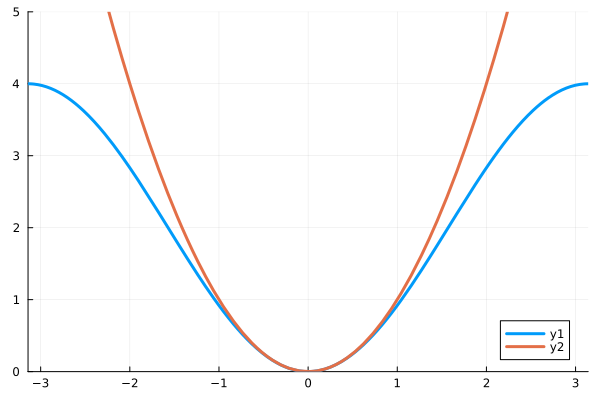

In [6]:
# Check stencil's symbol against symbol of continuous (second) differentiation
plot([theta -> 2 - 2*cos(theta),
        theta -> theta^2],
    xlims=(-pi, pi), ylim=(0, 5))

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function poisson_fd(x, spoints, forcing; left=(0, zero), right=(0, zero))
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        L[i, js] = -fdstencil(x[js], x[i], 2)
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], left[1])
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], right[1])
    rhs[1] = left[2](x[1])
    rhs[n] = right[2](x[n])
    L, rhs
end

poisson_fd (generic function with 1 method)

# Numerically computing symbols

In [90]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta') # "'" is the adjoint operator (NOTE: it takes complex conjugate!)
    vec(S * phi) # not! (S * phi)' Why?
end

theta = LinRange(-pi, pi, 10) # This is a column vector
# This is a row vector: [1 -2 1], and this is a column vector: [1, -2, 1]
symbol([-.5 0 .5], theta)
#symbol([1 -2 1], theta)

10-element Vector{ComplexF64}:
 0.0 - 1.2246467991473532e-16im
 0.0 - 0.6427876096865395im
 0.0 - 0.9848077530122081im
 0.0 - 0.8660254037844388im
 0.0 - 0.34202014332566877im
 0.0 + 0.34202014332566877im
 0.0 + 0.8660254037844385im
 0.0 + 0.9848077530122081im
 0.0 + 0.6427876096865395im
 0.0 + 1.2246467991473532e-16im

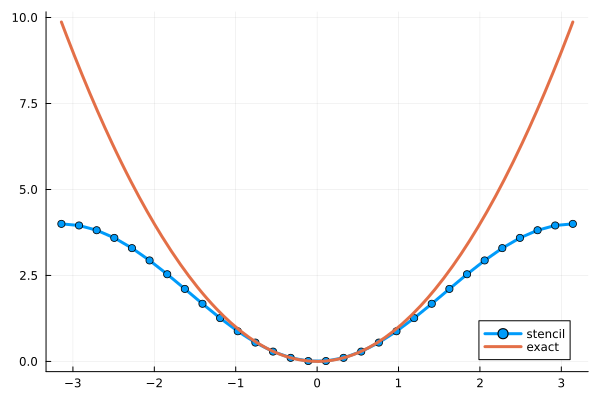

In [91]:
function plot_symbol(S, deriv, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    plot!(fig, th -> th^deriv, label="exact")
    fig
end

#plot_symbol([-.5 0 .5], 1)
plot_symbol([1 -2 1], 2)

# Stencils of high-order operators

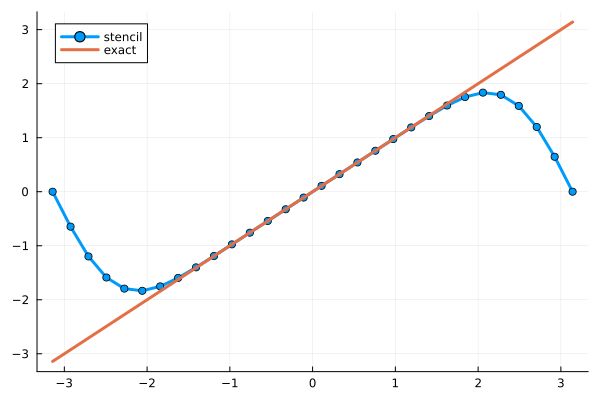

In [28]:
x = -5:5
plot_symbol(fdstencil(x, 0, 1), 1)

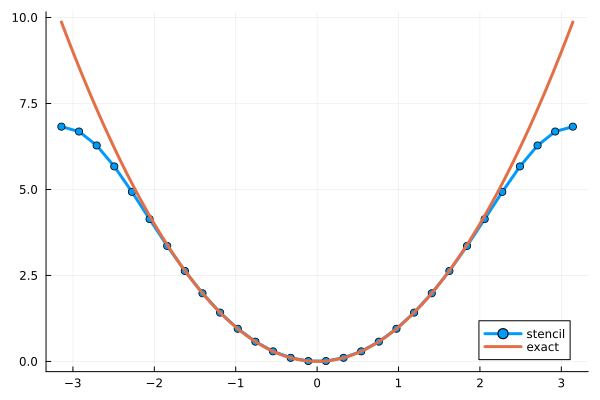

In [29]:
x = -5:5
plot_symbol(fdstencil(x, 0, 2), 2)

# Outlook on Fourier methods

* the Fourier modes $e^{i\theta x}$ and their multi-dimensional extensions are eigenvectors of **all** stencil-type operations
* "high frequencies" $[-\pi, \pi) \setminus [-\pi/2, \pi/2)$ are generally poorly resolved so we need to use a grid fine enough that important features are at low frequencies $[-\pi/2, \pi/2)$
* same technique can be used to study the inverse (and approximations thereof), as with multigrid and multilevel domain decomposition methods (later in the course)
* these methods can also be framed within the theory of (block) Toeplitz matrices

# Visualizing matrix transformations

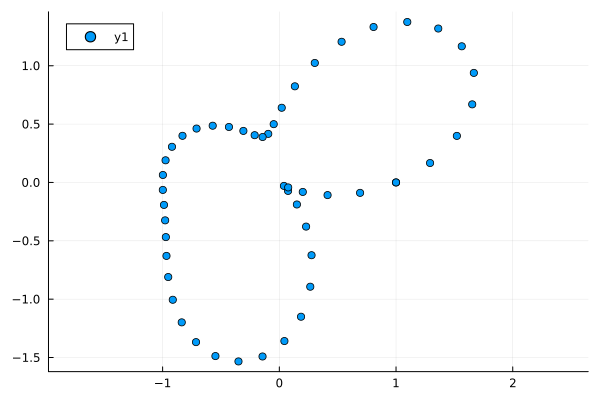

In [48]:
function peanut()
    theta = LinRange(0, 2*pi, 50) # n = 50 points
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    x = r .* cos.(theta)
    y = r .* sin.(theta)
    x, y
end
x, y = peanut()
scatter(x, y, aspect_ratio=:equal)

Group these points into a $2\times n$ matrix $X$. Note that multiplication by any matrix $A$ is applied to each column separately, i.e.,

$$ A \underbrace{\Bigg[ \mathbf x_1 \Bigg| \mathbf x_2 \Bigg| \dotsb \Bigg]}_X = \Bigg[ A \mathbf x_1 \Bigg| A \mathbf x_2 \Bigg| \dotsb \Bigg] $$

In [49]:
X = [x y]' # This has shape n x 2
size(X) # This has shape 2 x n

(2, 50)

# Visualizing the Singular Value Decomposition

2-element Vector{Float64}:
 2.6705835536519453
 0.8687969701106857

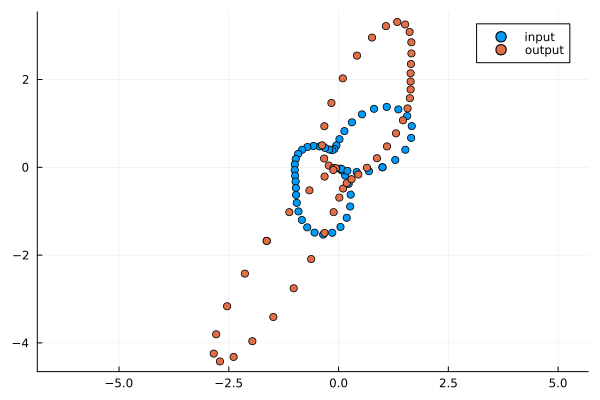

In [50]:
function tplot(A)
    x, y = peanut()
    X = [x y]'
    Y = A * X
    scatter(X[1,:], X[2,:], label="input", aspect_ratio=:equal)
    scatter!(Y[1,:], Y[2,:], label="output")
end

A = randn(2, 2)
display(svdvals(A))
tplot(A)

**Question:** What did the matrix $A$ do to the input points (the overall shape of the peanut)?

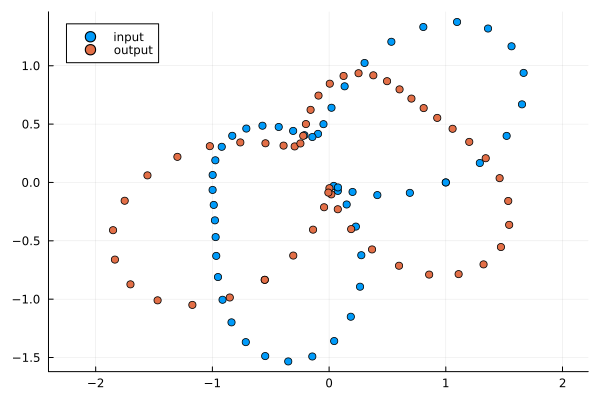

In [51]:
U, S, V = svd(A)
tplot(U)

**Question**: What does the matrix $U$ do to the input points?

# Condition number of interpolation

In [53]:
n = 20
source = LinRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P # In Julia, A / B = A * inv(B)
svdvals(A)

20-element Vector{Float64}:
 4141.821782616629
  756.1886116478678
   11.201394442862224
    5.200366811340577
    2.326389915746192
    2.2886531575424436
    2.282662654805574
    2.2826582312558124
    2.282657730773851
    2.2826577307583302
    2.282657729732285
    2.282657714190491
    2.2825938632420186
    2.282352200331264
    2.2484549739785127
    2.244923024404298
    1.9014541632719433
    1.7794033224108667
    1.009316785549192
    1.0064482710717733

**Group exercise**:

If `vander(x, n)` returns the first $n$ columns of the Vandermonde matrix, then what does $A$ (as defined above) do?

_Hint_: Recall that if we wanted to fit a polynomial $p(x) = \sum_j c_j x^j$ that goes through some points $x_i$ via a Vandermonde matrix, then the following was true:

$$  V c = p(x), $$

where $c$ is the vector of coefficients $c_j$ and $x$ is the vector of interpolation "source" nodes $x_i$.

Try writing down what $A p(s) $ is, where $s$ is the vector of interpolation points stored in the variable `source`.

Solution: $P$ is defined such that

$$ P c = p(s), $$

And let's call `vander(target, n)` a matrix $V$, and the first $n$ points in `target` $t$. Then 

$$ V c = p(t). $$

So $A = VP^{-1}$, and if $A$ acts on $p(s)$, we get

$$ Ap(s) = VP^{-1}p(s) = V c = p(t). $$

The interpretation is that $A$ is an interpolation matrix: it maps function values at the points in `source` to function values at `target`.

In [92]:
svdvals(A)

12-element Vector{Float64}:
 875.5534473932238
 852.3014989108352
 163.76945237935468
 153.5384179507023
  90.46533364845114
  66.66109349226521
  43.32186769323145
  25.286080065533156
  12.140204832379448
   3.965874173118786
   0.5860148010648404
   0.1794570778656536

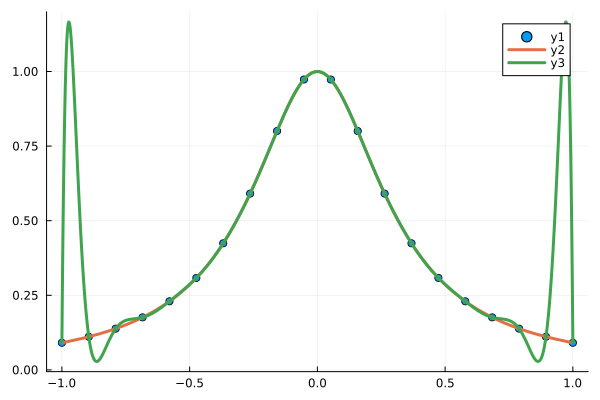

In [55]:
# Runge phenomenon -- equidistant interpolation nodes
runge(x) = 1 / (1 + 10*x^2)
y = runge.(source)
scatter(source, y)
plot!([runge,
        x -> (vander([x], n) / P * y)[1]])
# plot!(target, A * y)

# What went wrong? The bad singular vectors

$$ A = U \Sigma V^T $$


In [94]:
n = 11
source = LinRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P
U, S, V = svd(A)
S

11-element Vector{Float64}:
 34.77706851205524
 11.13125653860779
  3.200622823579756
  3.1551891145187843
  3.1464270560667247
  3.146390542844354
  3.1459494752514874
  2.900733962570026
  2.700731526422623
  1.2170432449283064
  1.1628054393968887

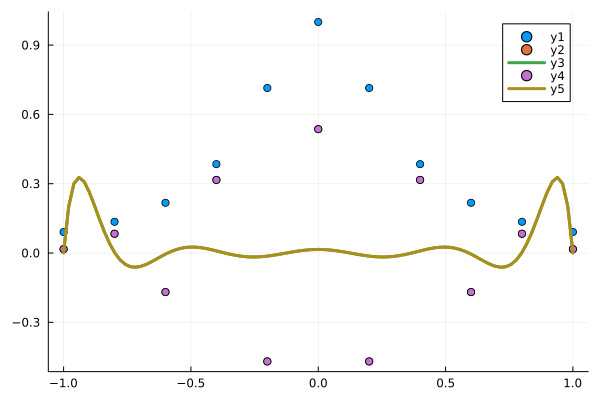

In [96]:
#scatter(source, runge.(source))
scatter!(source, V[:,1])
plot!(target, U[:,1])

# Choosing the source points

In [97]:
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

CosRange (generic function with 1 method)

In [98]:
n = 15
source = CosRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P
svdvals(A)

15-element Vector{Float64}:
 3.322445257960406
 3.295148962438839
 3.239022400818022
 3.1811090404014246
 3.070331398310828
 2.987280016794305
 2.812157783053938
 2.705974980411068
 2.4581412991003155
 2.320177305779101
 2.017320105389975
 1.7903748104690744
 1.5900555135944603
 1.037367695402304
 1.031069620176098

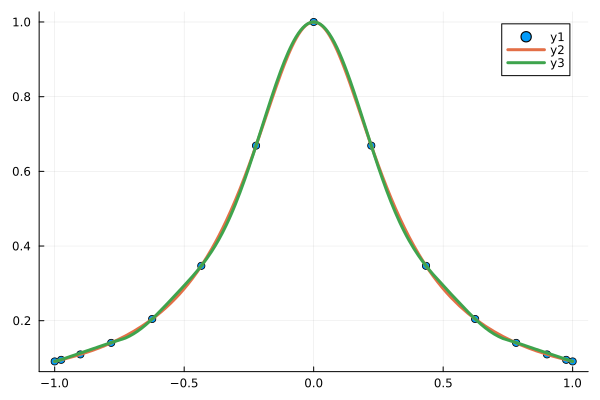

In [68]:
runge(x) = 1 / (1 + 10*x^2)
y = runge.(source)
scatter(source, y)
plot!([runge,
        x -> (vander([x], n) / P * y)[1]])

# Condition number of interpolation on `CosRange` points

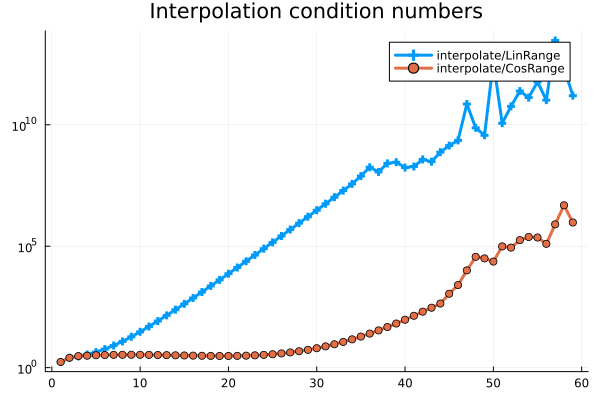

In [99]:
interpolate(source, target=LinRange(-1, 1, 100)) = vander(target, length(source)) / vander(source)

plot_cond(mat, points) = plot!([
        cond(mat(points(-1, 1, n)))
        for n in 2:60], label="$mat/$points", marker=:auto, yscale=:log10)

plot(title="Interpolation condition numbers")
plot_cond(interpolate, LinRange)
plot_cond(interpolate, CosRange)

# Vandermonde conditioning, stable algorithms

It is possible for interpolation to be well-conditioned, but construct it from ill-conditioned pieces.

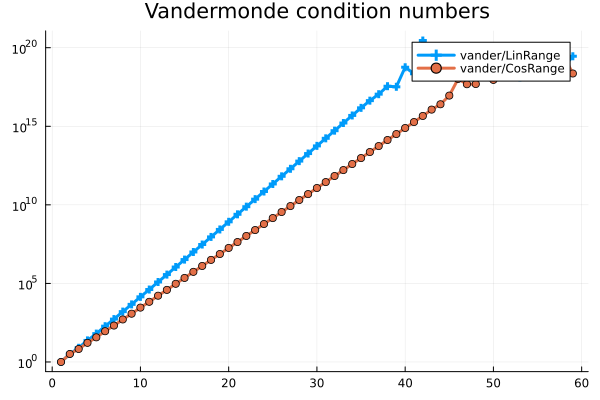

In [100]:
plot(title="Vandermonde condition numbers")
plot_cond(vander, LinRange)
plot_cond(vander, CosRange)

# Takeaways

* Two degrees of freedom in interpolation (and num diff/integration): 
    * nodes (stencil) $\to$ this is what we experimented with now,
    * modes (basis).
    

* Interpolation via the classical Vandermonde basis uses the _monomial basis_ $1, x, x^2, \ldots.$
* The condition number of this Vandermonde matrix blows up _exponentially quickly_, i.e. as $\mathcal{O}(c^n)$, where $c$ is some constant.

* The condition number of the Vandermonde matrix associated with a set of nodes doesn't tell the full story
    * E.g. even for the optimal (for smooth functions) set of nodes, defined by `CosRange`, it grows exponentially
    * Looks almost equally bad for `LinRange` and `CosRange`, but `LinRange` suffers from the Runge phenomenon, `CosRange` doesn't.
    * Condition number of the interpolation matrix based on these sets of nodes is better for estimating conditioning.
    * Even better is to analyze the stencil via e.g. SVD, and their symbol.
    * For `CosRange`, rule of thumb was to trust interpolation up until $\kappa \lessapprox 1/\varepsilon_M$.
    

* Can further improve conditioning by choosing a different basis, e.g. Lagrange interpolating polynomials (and the barycentric interpolation formula).

# Chebyshev polynomials

* The nodes in `CosRange` are the roots of the Chebyshev polynomials $T_n$, a set of special functions
* They are orthogonal with respect to the weight function $\frac{1}{\sqrt{1 - x^2}}$
* $\to$ they form a basis, an alternative to the monomial basis.
* We'll now make an alternative to the Vandermonde matrix by representing the interpolating polynomial in the Chebyshev basis,

$$ p(x) = \sum_{i=0}^{n-1} c_i T_i(x) $$

In [101]:
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

vander_chebyshev (generic function with 2 methods)

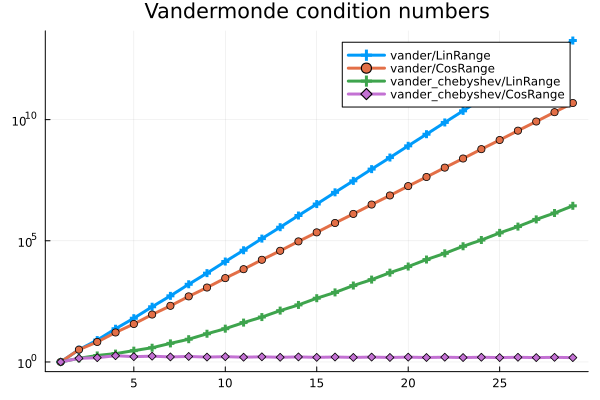

In [79]:
plot(title="Vandermonde condition numbers")
plot_cond(vander, LinRange)
plot_cond(vander, CosRange)
plot_cond(vander_chebyshev, LinRange)
plot_cond(vander_chebyshev, CosRange)

# Derivation of Chebyshev polynomials (supplemental)

Chebyshev polynomials are defined for non-negative integar $n$ as $$ T_n(x) = \cos (n \arccos(x)) .$$
This turns out to be a polynomial, but it's not obvious why.
Recall $$ \cos(a + b) = \cos a \cos b - \sin a \sin b .$$
Let $y = \arccos x$ and check
$$ \begin{split}
    T_{n+1}(x) &= \cos \big( (n+1) y \big) = \cos ny \cos y - \sin ny \sin y \\
    T_{n-1}(x) &= \cos \big( (n-1) y \big) = \cos ny \cos y + \sin ny \sin y
\end{split}$$
Adding these together produces
$$ T_{n+1}(x) + T_{n-1}(x) = 2\cos ny \cos y = 2 x \cos ny = 2 x T_n(x) $$
which yields a convenient recurrence:
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$

# Lagrange interpolating polynomials

Find the unique polynomial that is 0 at all but one `source` point.

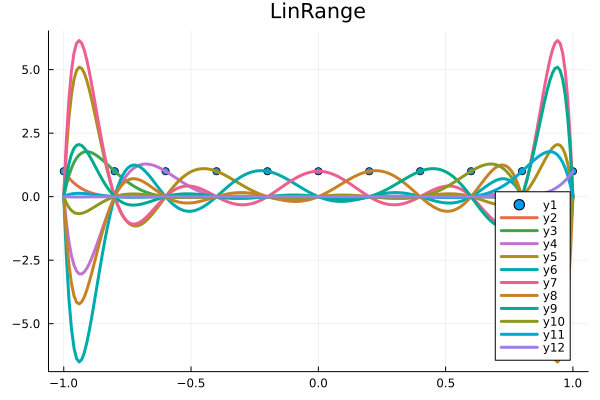

In [81]:
source = LinRange(-1, 1, 11)
target = LinRange(-1, 1, 200)
scatter(source, one.(source), title="LinRange")
plot!(target, interpolate(source, target))

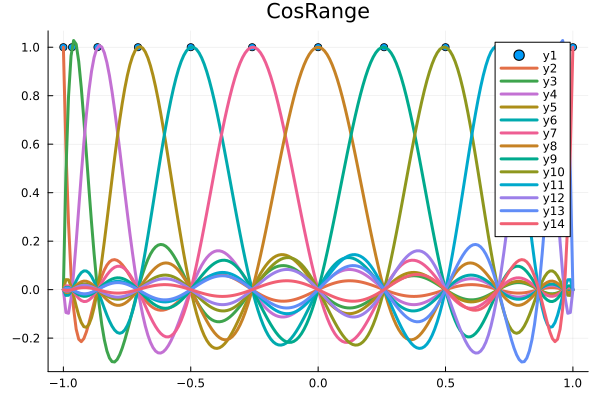

In [82]:
source = CosRange(-1, 1, 13)
target = LinRange(-1, 1, 200)
scatter(source, one.(source), title="CosRange")
plot!(target, interpolate(source, target))

# Differentiating via Chebyshev

We can differentiate Chebyshev polynomials using the recurrence

$$ \frac{T_k'(x)}{k} = 2 T_{k-1}(x) + \frac{T_{k-2}'(x)}{k-2} $$

which we can differentiate to evaluate higher derivatives.

In [83]:
function chebdiff(x, n=nothing)
    T = vander_chebyshev(x, n)
    m, n = size(T)
    dT = zero(T)
    dT[:,2:3] = [one.(x) 4*x]
    for j in 3:n-1
        dT[:,j+1] = j * (2 * T[:,j] + dT[:,j-1] / (j-2))
    end
    ddT = zero(T)
    ddT[:,3] .= 4
    for j in 3:n-1
        ddT[:,j+1] = j * (2 * dT[:,j] + ddT[:,j-1] / (j-2))
    end
    T, dT, ddT
end

chebdiff (generic function with 2 methods)

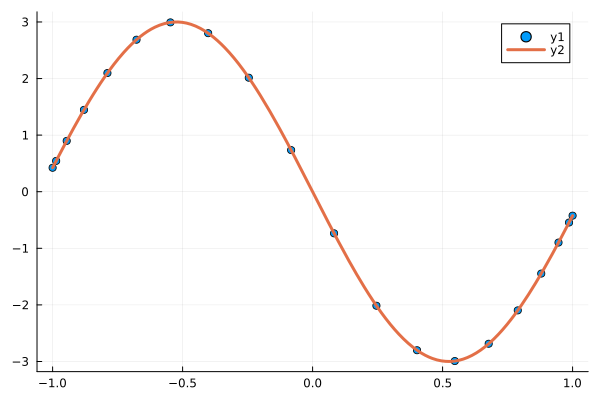

In [84]:
x = CosRange(-1, 1, 20)
T, dT, ddT = chebdiff(x)
c = T \ cos.(3x)
scatter(x, dT * c)
plot!(x -> -3sin(3x))

# Solving a BVP on Chebyshev nodes

In [85]:
function poisson_cheb(n, rhsfunc, leftbc=(0, zero), rightbc=(0, zero))
    x = CosRange(-1, 1, n)
    T, dT, ddT = chebdiff(x)
    L = -ddT
    rhs = rhsfunc.(x)
    for (index, deriv, func) in
            [(1, leftbc...), (n, rightbc...)]
        L[index,:] = (T, dT)[deriv+1][index,:]
        rhs[index] = func(x[index])
    end
    x, L / T, rhs
end

poisson_cheb (generic function with 3 methods)

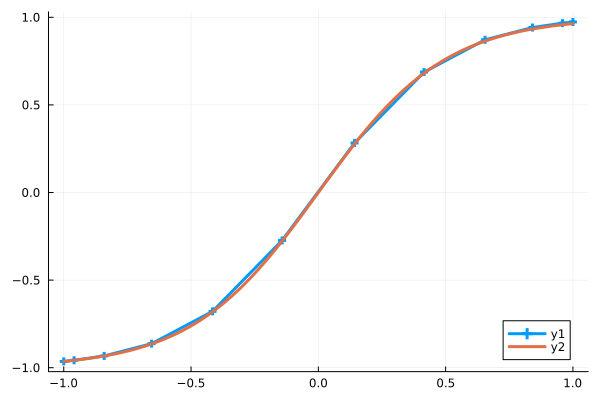

In [86]:
manufactured(x) = tanh(2x)
d_manufactured(x) = 2*cosh(2x)^-2
mdd_manufactured(x) = 8 * tanh(2x) / cosh(2x)^2
x, A, rhs = poisson_cheb(12, mdd_manufactured,
    (0, manufactured), (1, d_manufactured))
plot(x, A \ rhs, marker=:auto)
plot!(manufactured, legend=:bottomright)

# "spectral" (exponential) convergence

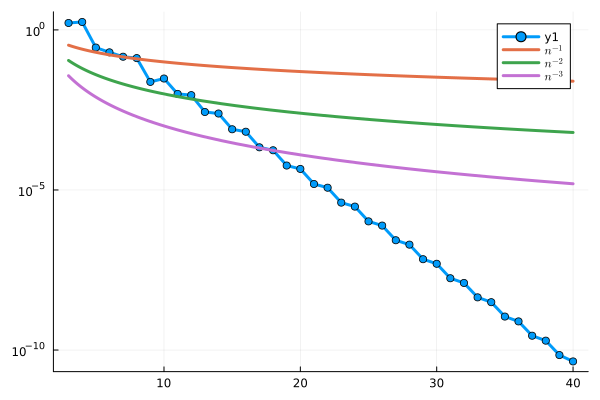

In [87]:
function poisson_error(n)
    x, A, rhs = poisson_cheb(n, mdd_manufactured, (0, manufactured), (1, d_manufactured))
    u = A \ rhs
    norm(u - manufactured.(x), Inf)
end

ns = 3:40
plot(ns, abs.(poisson_error.(ns)), marker=:circle, yscale=:log10)
ps = [1 2 3]
plot!([n -> n^-p for p in ps], label=map(p -> "\$n^{-$p}\$", ps))

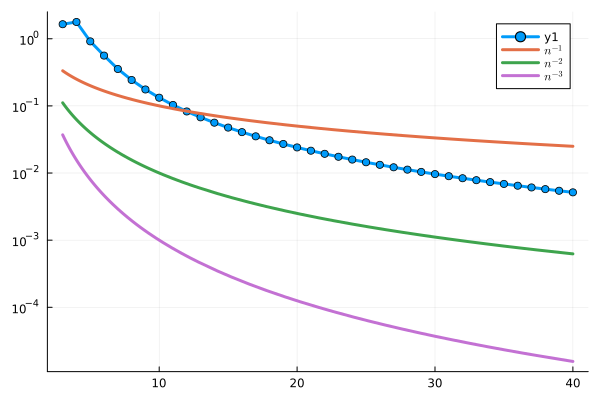

In [88]:
plot(ns, [poisson_fd_error(n, spoints=3) for n in ns], 
    marker=:circle, yscale=:log10)
plot!([n -> n^-p for p in ps], label=map(p -> "\$n^{-$p}\$", ps))